## Requirements

In [1]:
!pip install torch-geometric
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install optuna
!pip install "numpy<2"

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import pandas as pd
from torch_geometric.data import InMemoryDataset, Data
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import optuna
from optuna.trial import Trial
from functools import partial
import random
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx

## Data Preparation

**Load the dataset**

We start by reading the CSV file `dataset_LUMINAL_A_B.csv` using pandas.  
Each row represents one sample (a patient), and each column contains either the label (Luminal A or Luminal B) or a gene expression feature.

In [48]:
df = pd.read_csv("dataset_LUMINAL_A_B.csv")
df.head()

,l,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000273842.1,ENSG00000078237.5,ENSG00000146083.10,ENSG00000225275.4,ENSG00000158486.12,ENSG00000198242.12,...,ENSG00000088356.5,ENSG00000176752.6,ENSG00000223082.1,ENSG00000237714.1,ENSG00000200959.1,ENSG00000270971.2,ENSG00000267313.5,ENSG00000151632.15,ENSG00000269107.1,ENSG00000268889.1
0,Luminal A,2356.253792,26808.891103,57790.161586,0.0,71389.111749,381288.489078,0.0,1677.413295,1.969141e+06,...,113036.499486,0.0,20911.752405,13957.784680,1.047700e+06,0.0,1937.768563,10731.974977,0.0,0.0
1,Luminal A,0.000000,231.960840,115769.964478,0.0,77938.573803,238017.846096,0.0,0.000000,4.865670e+06,...,850405.301444,0.0,0.000000,2122.068451,0.000000e+00,0.0,5499.352680,2479.070667,0.0,0.0
2,Luminal A,0.000000,315.873536,44954.933833,0.0,58546.997851,249302.406604,0.0,270.107768,2.519212e+06,...,301948.579552,0.0,0.000000,481.622432,0.000000e+00,0.0,312.031830,4822.690978,0.0,0.0
3,Luminal A,1074.333108,0.000000,86991.783442,0.0,36082.381881,176274.146728,0.0,101.975469,2.855010e+06,...,293581.147891,0.0,0.000000,0.000000,0.000000e+00,0.0,0.000000,12631.387770,0.0,0.0
4,Luminal A,1395.887715,0.000000,65199.337535,0.0,91469.201926,263704.398926,0.0,66.248682,4.235429e+06,...,350449.557585,0.0,0.000000,1181.263740,0.000000e+00,0.0,0.000000,1626.418477,0.0,0.0


**Label extraction**

The first column contains the target variable: whether the sample belongs to subtype *Luminal A* or *Luminal B*.  
We convert this column into a PyTorch tensor where *Luminal A = 0*  and *Luminal B = 1*.  

In [4]:
label_column = df.iloc[:, 0]

raw_labels = torch.tensor(label_column.str.strip() == "Luminal B", dtype=torch.long)

**Features extraction**

All columns except the first are used as input features.  
We convert these values into a PyTorch tensor with `float64` precision so that the model can process them numerically.

In [5]:
feature_df = df.iloc[:, 1:]

raw_features = torch.tensor(feature_df.values, dtype=torch.float64)

**Remove empty (all-zero) features**

Some columns may contain only zeros, meaning they do not provide any useful information.  
We identify and drop those columns to clean the dataset.  
After filtering, we print how many columns were removed to keep track of the cleaning process.

In [6]:
cols_all_zero = feature_df.columns[(feature_df == 0).all()]
print(f"Found {len(cols_all_zero)} columns with empty values")

filtered_features = feature_df.drop(columns = cols_all_zero)

Found 84 columns with empty values


### Standard Scaler

**Feature scaling**

We standardize the features using *StandardScaler*.  
This transformation ensures that each feature has a *mean close to 0 and a standard deviation of 1*, preventing features with larger numeric ranges from dominating the analysis.  
Scaling is also important to avoid *exploding or vanishing gradients* during neural network training.

After scaling, we print:
- The mean (should be near 0)
- The variance (should be around 1)
- The shape of the feature matrix

In [7]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(filtered_features.values)

print(f"Mean: {features_scaled.mean()}")
print(f"Variance: {features_scaled.std()}")
print(f"Shape: {features_scaled.shape}")

Mean: -7.480393939905106e-19
Variance: 1.0
Shape: (100, 938)


### PCA

Our dataset has a very high number of dimensions (938 features).  
In such cases, it's difficult to analyze correlations or visualize patterns between patients.  
**Principal Component Analysis (PCA)** helps by projecting the dataset onto a lower-dimensional space while preserving as much variance (information) as possible.  
This step simplifies the data, making it easier for models to learn meaningful patterns and reducing overfitting risks.

**Set random seeds for reproducibility**

Machine learning models and transformations (like PCA) often involve random initialization.  
To ensure that results are reproducible, we define a helper function `set_common_seeds()` that synchronizes random seeds across:
- Python’s built-in random generator  
- NumPy  
- PyTorch (both CPU and GPU)

Setting a global seed (e.g., 42) ensures identical results across different runs.


In [8]:
seed_pool = [
    12, 37, 58, 93, 117, 142, 199, 224, 255, 312,
    345, 389, 415, 456, 489, 512, 578, 603, 644, 677,
    702, 745, 799, 820, 856, 901, 933, 974, 1003, 1044
]

def set_common_seeds(seed):

    if seed is None:
        return

    # Python
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)

    # CUDA
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [9]:
global_seed = 42
set_common_seeds(global_seed)

**Apply PCA**

We apply PCA with `target_dims = 40`, which means we project our data into 40 principal components.  
The choice of 40 is a good balance between preserving variance and simplifying the model.  
We use the global seed for consistent random state initialization.  

The output `reduced_data` is then converted into a PyTorch tensor (`normalized_data`) to prepare it for use in downstream models.


In [10]:
seed = global_seed
target_dims = 40

if seed is not None:
  pca = PCA(n_components=target_dims, random_state=seed)
else:
  pca = PCA(n_components=target_dims)

reduced_data = pca.fit_transform(features_scaled)

normalized_data = torch.tensor(reduced_data, dtype=torch.float32)

### Masking

**Create training, validation, and test masks**

This function generates boolean masks to split the dataset into *training*, *validation*, and *test* sets.

How it works:
1. The user specifies the number of samples (`points`) and the desired split ratios (`train_split`, `val_split`, `test_split`), which must sum to 1.0.  
2. A random permutation of all sample indices is created to shuffle the data.  
   - If a seed is provided, this permutation is reproducible, ensuring consistent results across runs.  
3. Based on the split ratios, it assigns indices to the training, validation, and test sets.  
4. Finally, it creates boolean masks (`torch.BoolTensor`) for each subset, marking which samples belong to each group.

In [11]:
def create_dataset_masks(
    points: int,
    train_split: float,
    val_split: float,
    test_split: float,
    seed: int,
):
    total = train_split + val_split + test_split

    if abs(total - 1.0) > 1e-6:
        raise ValueError(f"Splits must sum to 1.0, got {total}")

    if seed is not None:
        generator = torch.Generator().manual_seed(seed)
        perm = torch.randperm(points, generator=generator)
    else:
        perm = torch.randperm(points)

    num_train = int(train_split * points)
    num_val = int(val_split * points)
    #num_test = points - num_train - num_val

    train_idx = perm[:num_train]
    val_idx = perm[num_train:num_train + num_val]
    test_idx = perm[num_train + num_val:]

    train_mask = torch.zeros(points, dtype=torch.bool)
    val_mask = torch.zeros(points, dtype=torch.bool)
    test_mask = torch.zeros(points, dtype=torch.bool)

    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True

    return train_mask, val_mask, test_mask

**Merge dataset masks**

This utility function takes two boolean masks and combines them using a logical OR operation.  

This is useful to merge training and validation sets when retraining a final model on the entire non-test data.

In [12]:
def merge_dataset_masks(mask1, mask2):
    combined = mask1 | mask2
    return combined

## Correlation

### Pearson Correlation

**Pearson correlation between patients**

We first compute the *Pearson correlation matrix* between patients using the PCA-transformed data (`normalized_data`).  

To do this, we convert the tensor into a pandas DataFrame and then use `.T.corr(method="pearson")`, transposing the matrix so that:
- Each *row represents a patient*
- The correlation is computed *patient vs. patient*, not feature vs. feature

The resulting matrix is of shape *(N_patients × N_patients)*, where each entry `(i, j)` measures the linear similarity between patient *i* and patient *j*.


In [13]:
df_temp = pd.DataFrame(normalized_data.numpy())
pearson_corr = df_temp.T.corr(method="pearson")
print(pearson_corr)

          0         1         2         3         4         5         6   \
0   1.000000 -0.222112 -0.129810 -0.177494 -0.292430 -0.167267 -0.234750   
1  -0.222112  1.000000 -0.160178 -0.021068  0.030770  0.231106 -0.064765   
2  -0.129810 -0.160178  1.000000  0.371974 -0.000328  0.022772  0.083335   
3  -0.177494 -0.021068  0.371974  1.000000  0.093022  0.019221 -0.025553   
4  -0.292430  0.030770 -0.000328  0.093022  1.000000 -0.188551 -0.129454   
..       ...       ...       ...       ...       ...       ...       ...   
95 -0.038895 -0.135388  0.017758 -0.154317  0.371302 -0.018396  0.091651   
96 -0.302158  0.042367  0.035605 -0.176551  0.251483 -0.106666  0.148481   
97 -0.064457 -0.102507 -0.117200 -0.120276  0.006490 -0.109981 -0.100624   
98  0.003868 -0.087827  0.181327  0.049561  0.112439  0.006137 -0.234087   
99 -0.042396  0.010229 -0.079894 -0.069936 -0.030060 -0.067754 -0.058524   

          7         8         9   ...        90        91        92        93  \
0   0.

**Visualize each patient's correlation profile**

To better understand how each patient relates to all others, we:
- Take the *absolute value* of the Pearson correlation matrix to focus on the strength of the relationship, regardless of sign.  
- Create a grid of subplots, where each small plot shows the correlation of **one patient with all other patients**.


Each subplot:
- Plots the correlation values for a single patient
- Has a fixed y-axis range from -1 to 1 for consistency
- Displays a small title like `P0`, `P1`, ..., indicating the patient index

This grid of plots provides an overview of how similar each patient is to the rest of the cohort.

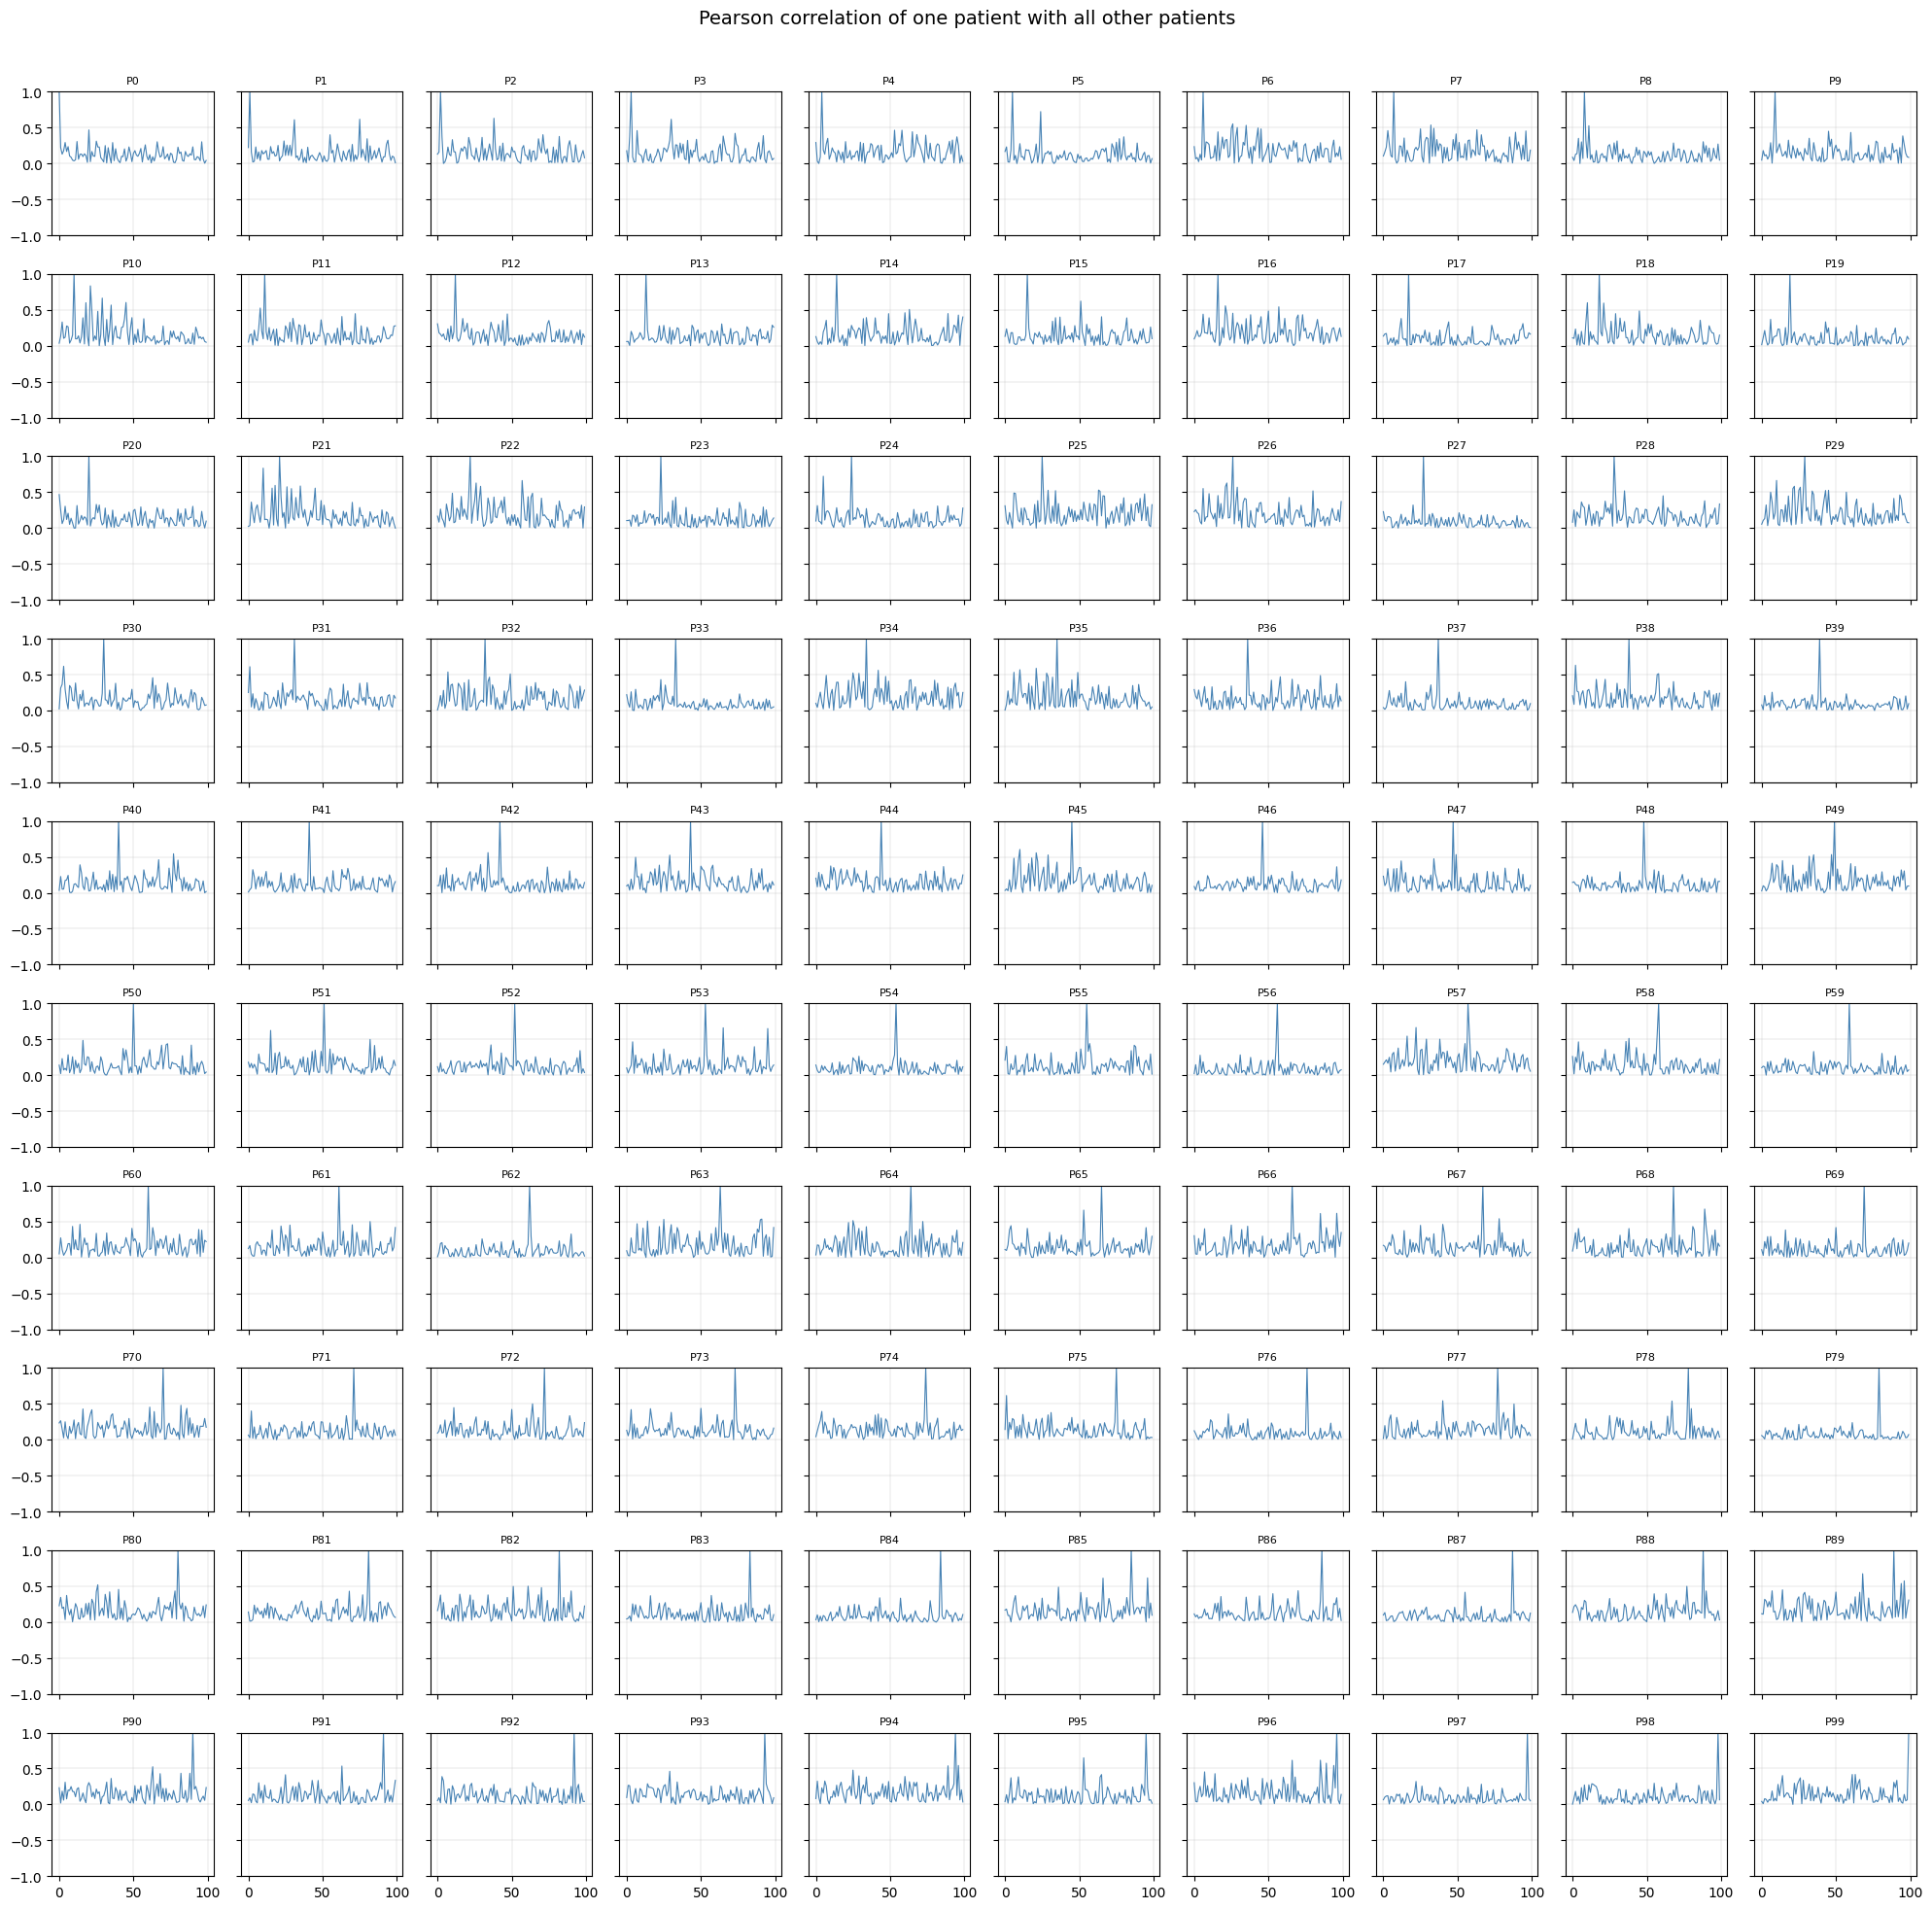

In [15]:
df_temp = pearson_corr.abs()

n_patients = df_temp.shape[0]
cols = 10
rows = int(np.ceil(n_patients / cols))

fig, axes = plt.subplots(rows, cols, figsize=(20, 20), sharex=True, sharey=True)

ymin, ymax = -1, 1

for i, ax in enumerate(axes.flat):
    if i < n_patients:
        ax.plot(df_temp.iloc[i, :].values, color='steelblue', linewidth=0.8)
        ax.set_title(f"P{i}", fontsize=8)
        ax.set_ylim(ymin, ymax)
        ax.grid(True, linewidth=0.2)
    else:
        ax.axis('off')

fig.suptitle("Pearson correlation of one patient with all other patients", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

**Histogram of Pearson correlation values**

We use histograms to inspect the distribution of correlation values:
- First, we plot a histogram of the raw Pearson correlation coefficients.  
- Then, we plot a histogram of the *absolute* correlations, which treats strong negative and strong positive correlations in the same way.

These histograms help us understand:
- Whether most patient pairs are weakly or strongly correlated  
- How many pairs show moderate or high similarity

Finally, we convert the absolute Pearson correlation matrix into a PyTorch tensor (`pearson_abs_tensor`) for potential downstream use in models or graph-based methods.

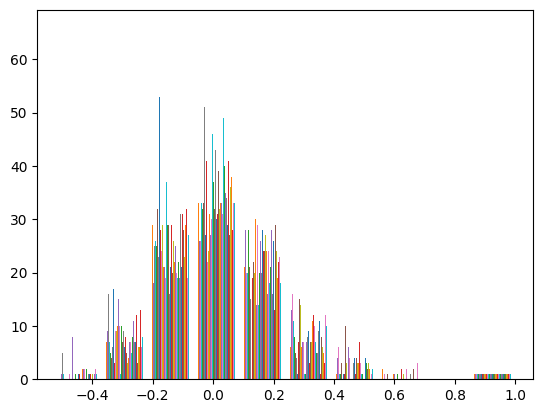

In [16]:
plt.hist(pearson_corr)
plt.show()

This histogram contains both positive and negative values, because Pearson correlation measures the linear relationship, which can be either direct (`> 0`) or inverse (`< 0`).

The fact that most of the mass is close to 0 indicates that most patient pairs do not have a strong linear relationship; the few bins far from 0 correspond to pairs that are very similar or very opposite.

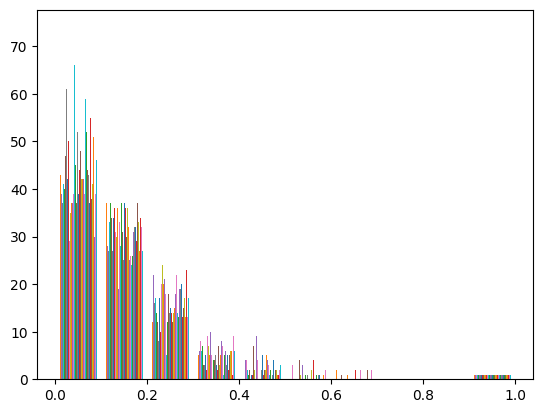

In [17]:
pearson_abs = pearson_corr.abs()
plt.hist(pearson_abs)
plt.show()

pearson_abs_tensor = torch.tensor(pearson_abs.values, dtype=torch.float32)

In this histogram all values are compressed between 0 and 1, so we only look at the strength of the correlation, ignoring its sign.

The concentration of values around 0–0.3 suggests that most patients are weakly correlated, while the tails toward 0.7–1 indicate a few pairs with very similar PCA profiles (potential groups or clusters).

### Spearman Correlation

**Spearman correlation between patients**

Next, we compute the *Spearman correlation matrix* using `.corr(method="spearman")`.  

Unlike Pearson, which measures *linear* relationships, Spearman is based on *rank correlation*, making it more robust to non-linear but monotonic relationships.

We then visualize the distribution of Spearman coefficients with a histogram, allowing us to compare how rank-based similarity behaves compared to Pearson correlation.

          0         1         2         3         4         5         6   \
0   1.000000  0.133021  0.003600  0.113111  0.068755  0.007801 -0.010237   
1   0.133021  1.000000  0.023762 -0.097714 -0.045065  0.309847  0.038932   
2   0.003600  0.023762  1.000000  0.120828  0.078056 -0.124164  0.056370   
3   0.113111 -0.097714  0.120828  1.000000  0.009817  0.009961  0.068995   
4   0.068755 -0.045065  0.078056  0.009817  1.000000 -0.065587 -0.016622   
..       ...       ...       ...       ...       ...       ...       ...   
95 -0.052733 -0.044764 -0.156628 -0.009049  0.195656 -0.120468  0.200456   
96  0.183918  0.019334 -0.066343  0.082436  0.137414  0.054341  0.136802   
97 -0.010549  0.132589  0.350315  0.007909 -0.041356  0.089385  0.080720   
98 -0.021122  0.144554  0.048269 -0.123156 -0.019526 -0.060126 -0.045821   
99  0.121140 -0.066883  0.081140  0.151911 -0.015134 -0.001836 -0.011377   

          7         8         9   ...        90        91        92        93  \
0   0.

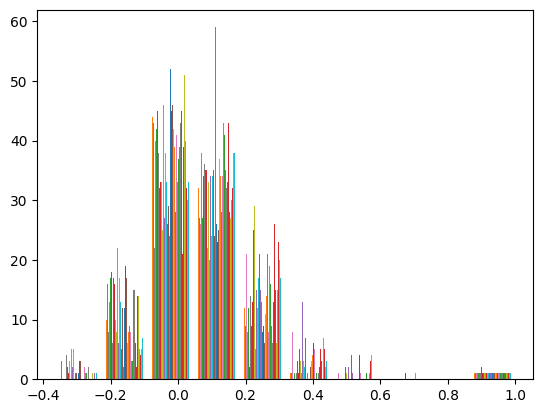

In [18]:
spearman_corr = df_temp.T.corr(method="spearman")
print(spearman_corr)

plt.hist(spearman_corr)
plt.show()

The fact that most bars are concentrated around values close to 0 suggests that, in terms of rank ordering of features, most patient pairs are only weakly related.

The fewer bars extending toward higher positive values indicate a small number of patient pairs that share a very similar ranking of features, which may correspond to biologically similar profiles or potential subgroups.

### Kendall Correlation

**Kendall correlation between patients**

Finally, we compute the *Kendall correlation matrix* using `.corr(method="kendall")`.  
Kendall’s Tau is another rank-based correlation measure that evaluates the *concordance and discordance* between pairs of observations.

Again, we use a histogram to visualize the distribution of Kendall correlation values.  


          0         1         2         3         4         5         6   \
0   1.000000  0.087273  0.010101  0.070707  0.055758  0.005657 -0.002828   
1   0.087273  1.000000  0.010505 -0.056566 -0.025455  0.206465  0.021010   
2   0.010101  0.010505  1.000000  0.081212  0.054141 -0.079192  0.042424   
3   0.070707 -0.056566  0.081212  1.000000  0.007273  0.011313  0.047273   
4   0.055758 -0.025455  0.054141  0.007273  1.000000 -0.048081 -0.013737   
..       ...       ...       ...       ...       ...       ...       ...   
95 -0.036364 -0.024646 -0.101010 -0.007273  0.127273 -0.077172  0.138990   
96  0.132121  0.021818 -0.047273  0.054545  0.094545  0.043636  0.086061   
97 -0.006465  0.094141  0.245657  0.003232 -0.030303  0.060202  0.047677   
98 -0.014545  0.104646  0.025859 -0.080000 -0.012525 -0.045657 -0.030707   
99  0.082424 -0.040808  0.063030  0.101010 -0.009293 -0.008485 -0.007273   

          7         8         9   ...        90        91        92        93  \
0   0.

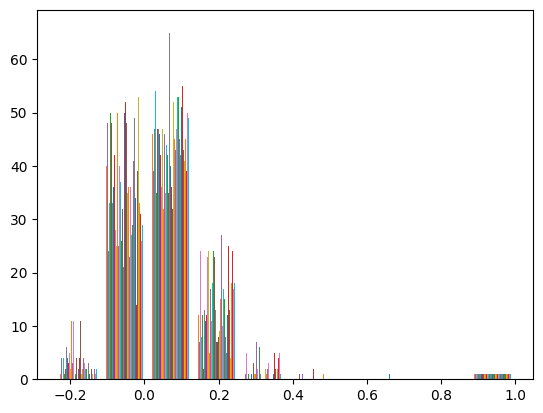

In [19]:
kendall_corr = df_temp.T.corr(method="kendall")
print(kendall_corr)

plt.hist(kendall_corr)
plt.show()

The considerations made for Spearman's histogram are still valid.

In our case the most suitable metric is Pearson in absolute value because we are interested in the strength of the relationship.

## Edge List

### Threshold


**Graph construction with a correlation threshold**

The function `create_sparse_edges_with_threshold()` builds a graph directly from the correlation matrix between patients.

- `features_correlation` is a square matrix where entry `(i, j)` represents the similarity between patient *i* and patient *j* (e.g., absolute Pearson correlation).  
- We loop over all pairs `(i, j)` and add an edge whenever the correlation is *greater than a chosen threshold*.  
- Self-edges `(i == j)` are skipped, so nodes are not connected to themselves.  
- The output `edge_index` is a 2 × E tensor listing all directed edges, which is compatible with common GNN libraries.

This approach keeps only “strong” relationships and produces a *sparse graph* whose density depends directly on the threshold value.

In [20]:
def create_sparse_edges_with_threshold(
    features_correlation: torch.Tensor, threshold: float
):
    n = int(features_correlation.shape[0])

    edges = []

    for i in range(n):
        for j in range(n):

            # skip identity column
            if i == j:
                continue

            if features_correlation[i, j] > threshold:
                edges.append((i, j))

    edge_index = torch.tensor(edges).T

    return edge_index

### KNN

**Graph construction with k-nearest neighbors (kNN)**

The function `create_sparse_edges_with_knn()` constructs a graph where each patient is connected to its *k most similar neighbors*.

- We convert the similarity matrix into a distance matrix using `distance = 1 - correlation`, so higher correlation means smaller distance.  
- The diagonal is set to infinity to avoid selecting the node itself as a neighbor.  
- For each patient *i*, we use `torch.topk` to find the indices of the *k smallest distances* (i.e., the k nearest neighbors).
- For each neighbor, we add both `(i, neighbor)` and `(neighbor, i)` so that the graph is undirected.

This method guarantees that each node has (at least) k connections, producing a graph with *more uniform degree* compared to simple thresholding.

In [21]:
def create_sparse_edges_with_knn(features_correlation: torch.Tensor, k: int):
    n = int(features_correlation.shape[0])
    distance_matrix = 1 - features_correlation

    # used to avoid including the node itself
    distance_matrix.fill_diagonal_(float('inf'))

    _, indices = torch.topk(distance_matrix, k=k, dim=1, largest=False)

    edges = []

    for i in range(n):
        for neighbor_idx in indices[i]:
            edges.append((i, neighbor_idx.item()))

            edges.append((neighbor_idx.item(), i))

    edge_index = torch.tensor(edges).T

    return edge_index

**Train–test node split**

After building the graph, we create a simple *train/test split over the nodes*:

- `num_nodes` is the number of patients in the graph.  
- We randomly permute all node indices and assign 70% to the *training set* and 30% to the *test set*.  
- Two boolean masks (`train_mask` and `test_mask`) are created, where `True` indicates that a node belongs to the corresponding split.

These masks are later used to evaluate GNN models only on the test nodes while training on the training nodes.

In [22]:
num_nodes = pearson_abs.shape[0]

num_train = int(0.7 * num_nodes)
num_test = int(0.3 * num_nodes)

# Random permutation of the indices
perm = torch.randperm(num_nodes)

train_idx = perm[: num_train]
test_idx = perm[num_train :]

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_idx]=True
test_mask[test_idx]=True

## Network

**GNN architecture**

The `GNN` class implements a multi-layer Graph Convolutional Network (GCN) using `GCNConv` layers.  

A ReLU activation and dropout are applied *after every layer except the last one*, which outputs the raw logits used for classification.

In [23]:
class GNN(torch.nn.Module):
    def __init__(
        self, input_channels, hidden_channels, output_channels, layers, dropout
    ):
        super().__init__()

        self.dropout = dropout
        self.convs = torch.nn.ModuleList()

        self.convs.append(GCNConv(input_channels, hidden_channels))

        for _ in range(layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))

        self.convs.append(GCNConv(hidden_channels, output_channels))

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)

            if i < len(self.convs) - 1:
                x = x.relu()
                x = F.dropout(x, p=self.dropout, training=self.training)

        return x

**Accuracy computation**

The function `calculate_accuracy()` takes the model output `out`, the ground‑truth `labels`, and a boolean `mask`.  
It selects only the nodes indicated by the mask, compares the predicted class (argmax over logits) with the true labels, and returns the fraction of correct predictions as accuracy.

In [24]:
def calculate_accuracy(out, labels, mask):
    prediction = out.argmax(dim=1)
    correct_labels = prediction[mask] == labels[mask]
    accuracy = int(correct_labels.sum()) / int(mask.sum())
    return accuracy

**Training loop with early stopping**

The function `train_network()` trains the GNN on a given graph using:
- Cross‑entropy loss on the nodes selected by `train_mask`.  
- The Adam optimizer with a specified learning rate and weight decay.  

At each epoch, the model is trained on the training nodes and then evaluated on both the training and evaluation (validation) masks.  
The *best validation accuracy* is tracked: when it improves, the current model state is saved; otherwise a `patience_counter` is increased.  
If the counter reaches the `patience` value, training stops early (early stopping) to prevent overfitting and unnecessary computation.  

At the end, the best saved weights are restored, and the function returns the final training accuracy, validation accuracy, and the best validation accuracy achieved during training.

In [25]:
def train_network(
    model: GNN,
    device,
    features,
    labels,
    edge_index,
    train_mask,
    eval_mask,
    epochs,
    patience,
    learning_rate,
    weight_decay,
    verbose=False,
):
    model = model.to(device)
    features = features.to(device)
    labels = labels.to(device)
    edge_index = edge_index.to(device)
    train_mask = train_mask.to(device)
    eval_mask = eval_mask.to(device)

    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay
    )
    criterion = torch.nn.CrossEntropyLoss()

    best_eval_accuracy = 0
    patience_counter = 0
    best_state = None

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(features, edge_index)
        loss = criterion(out[train_mask], labels[train_mask])
        loss.backward()
        optimizer.step()

        model.eval()

        with torch.no_grad():
            out = model(features, edge_index)
            train_accuracy = calculate_accuracy(out, labels, train_mask)
            eval_accuracy = calculate_accuracy(out, labels, eval_mask)

        if verbose:
            print(
                f"Epoch {epoch:03d} | Loss={loss:.4f} | Train={train_accuracy:.4f} | Eval={eval_accuracy:.4f}"
            )

        if eval_accuracy > best_eval_accuracy:
            best_eval_accuracy = eval_accuracy
            patience_counter = 0
            best_state = {k: v.clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1

        if patience_counter >= patience:
            if verbose:
                print(f"Early stopping at epoch {epoch:03d}")
            break

    if best_state is not None:
        model.load_state_dict(best_state)

    return train_accuracy, eval_accuracy, best_eval_accuracy

## Optimization

**Hyperparameter optimization objective**

The `objective()` function defines the search space for Optuna.  

For each trial, it samples:
- `hidden_channels` from {8, 16, 32, 64, 128}  
- `num_layers` between 2 and 5  
- `dropout` between 0.1 and 0.7  
- `learning_rate` in `[1e-4, 1e-2]` (log‑scale)  
- `weight_decay` in `[1e-6, 1e-3]` (log‑scale)  


A new `GNN` model is built with these hyperparameters and trained using `train_network()`.  
The function returns the **best validation accuracy** for that trial, which Optuna will try to maximize.

In [26]:
def objective(
    trial: Trial, device, features, labels, edge_index, train_mask, eval_mask
):

    hidden_channels = trial.suggest_categorical("hidden_channels", [8, 16, 32, 64, 128])
    num_layers = trial.suggest_int("num_layers", 2, 5)
    dropout = trial.suggest_float("dropout", 0.1, 0.7)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    epochs = 1000
    patience = 100
    input_channels = features.size(1)

    model = GNN(
        input_channels=input_channels,
        hidden_channels=hidden_channels,
        output_channels=2,
        layers=num_layers,
        dropout=dropout,
    )

    train_accuracy, eval_accuracy, best_eval_accuracy = train_network(
        model=model,
        device=device,
        features=features,
        labels=labels,
        edge_index=edge_index,
        train_mask=train_mask,
        eval_mask = eval_mask,
        epochs=epochs,
        patience=patience,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        verbose=False,
    )

    return best_eval_accuracy

**Run hyperparameter optimization**

The function `execute_hpo()` wraps the `objective()` function, fixing the dataset, device, and masks, and leaves only the trial‑dependent hyperparameters to Optuna.  
It then creates an Optuna study with `direction="maximize"` and runs `n_trials` optimization steps.  

After the search, it prints:
- The best validation accuracy found (`study.best_value`)  
- The corresponding hyperparameters (`study.best_params`)  

This provides a principled way to select a good GNN configuration before final evaluation.

In [27]:
def execute_hpo(
    device, features, labels, edge_index, train_mask, eval_mask, trials=100
):

    wrapped_objective = partial(
        objective,
        device=device,
        features=features,
        labels=labels,
        edge_index=edge_index,
        train_mask=train_mask,
        eval_mask=eval_mask,
    )

    study = optuna.create_study(direction="maximize")
    study.optimize(wrapped_objective, n_trials=trials)

    print("Best value:", study.best_value)
    print("Best params:", study.best_params)

    return study

**Mean accuracy and confidence interval**

The function `mean_confidence_interval()` computes the mean accuracy and a 95% confidence interval using either the t‑distribution or the normal distribution.  
After each new seed is evaluated, the current mean and confidence interval of the `accuracies` list are printed.  

This provides a statistically more stable estimate of model performance, showing not only the average test accuracy but also the variability across different random splits.

In [28]:
def mean_confidence_interval(data, confidence=0.95, dist="t"):
    a = np.array(data)
    n = len(a)
    mean = np.mean(a)
    sem = np.std(a, ddof=1) / np.sqrt(n)

    if dist == "t":
        lower, upper = stats.t.interval(confidence, df=n - 1, loc=mean, scale=sem)
    elif dist == "norm":
        lower, upper = stats.norm.interval(confidence, loc=mean, scale=sem)
    else:
        raise ValueError("dist must be 't' or 'norm'")

    return mean, lower, upper

### Threshold

We build the graph using the *absolute Pearson correlation* as similarity and a **threshold strategy**.

Each node (patient) is then split into train/validation/test using `create_dataset_masks()` with an 80/10/10 ratio and a fixed global seed for reproducibility.  
These masks are passed to Optuna during hyperparameter optimization.

In [ ]:
global_seed = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

number_of_nodes = int(normalized_data.shape[0])
number_of_dimensions = int(normalized_data.shape[1])
number_of_patients = n_patients

features_correlation = pearson_abs_tensor

edge_index = create_sparse_edges_with_threshold(features_correlation, 0.4)

train_mask, val_mask, test_mask = create_dataset_masks(
    points=number_of_patients,
    train_split=0.8,
    val_split=0.1,
    test_split=0.1,
    seed=global_seed,
)

study = execute_hpo(
    device = device,
    features=normalized_data,
    labels=raw_labels,
    edge_index=edge_index,
    train_mask=train_mask,
    eval_mask=val_mask,
    trials=100,
)


The best values are:

```
Best value: 1.0
Best params: {'hidden_channels': 32, 'num_layers': 2, 'dropout': 0.3749341644399074, 'learning_rate': 0.0005434092382459364, 'weight_decay': 1.1544729236398864e-06}
```



### KNN

We build the graph using the *absolute Pearson correlation* as similarity and a **k‑nearest neighbors strategy**.

Each node (patient) is then split into train/validation/test using `create_dataset_masks()` with an 80/10/10 ratio and a fixed global seed for reproducibility.  
These masks are passed to Optuna during hyperparameter optimization.


In [ ]:
global_seed = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

number_of_nodes = int(normalized_data.shape[0])
number_of_dimensions = int(normalized_data.shape[1])
number_of_patients = n_patients

features_correlation = pearson_abs_tensor

edge_index = create_sparse_edges_with_knn(features_correlation, k=5)

train_mask, val_mask, test_mask = create_dataset_masks(
    points=number_of_patients,
    train_split=0.8,
    val_split=0.1,
    test_split=0.1,
    seed=global_seed,
)

study = execute_hpo(
    device = device,
    features=normalized_data,
    labels=raw_labels,
    edge_index=edge_index,
    train_mask=train_mask,
    eval_mask=val_mask,
    trials=100,
)


The best values are:


```
Best value: 0.9
Best params: {'hidden_channels': 64, 'num_layers': 2, 'dropout': 0.39362822139501963, 'learning_rate': 0.0021693237184535687, 'weight_decay': 0.0004123291855838868}
```



Clearly the results obtained from the HPO are then fed to the network to get the best scenario and effectively run the training.

## Training

**Visualizing patient–patient correlations**

The function `show_correlations()` plots, for each patient, the absolute correlation with all other patients.   
- A grid of subplots is created (10 columns by as many rows as needed), where each small plot corresponds to a single patient `Pi`.  
- In each subplot, we draw the correlation values of that patient with all others, with a fixed y‑axis range from −1 to 1 and a light grid.

This visualization provides a quick overview of how strongly each patient is connected to the rest of the cohort in terms of similarity.

In [30]:
def show_correlations(features_correlation, title="Absolute Pearson correlations"):
    corr = features_correlation.detach().cpu().abs()

    n_patients = corr.shape[0]
    cols = 10
    rows = int(np.ceil(n_patients / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(20, 20), sharex=True, sharey=True)
    ymin, ymax = -1, 1

    axes = np.ravel(axes)

    for i, ax in enumerate(axes):
        if i < n_patients:
            row_vals = corr[i].numpy()
            ax.plot(row_vals, color='steelblue', linewidth=0.8)
            ax.set_title(f"P{i}", fontsize=8)
            ax.set_ylim(ymin, ymax)
            ax.grid(True, linewidth=0.2)
        else:
            ax.axis('off')

    fig.suptitle(title, fontsize=14)
    plt.tight_layout(rect=(0, 0, 1, 0.97))
    plt.show()

**Graph visualization**

The function `visualize_graph()` converts a `Data` object into a NetworkX graph using `to_networkx()`.  
- Node positions are computed with `nx.spring_layout`, a force‑directed layout where edges act like springs and nodes repel each other.  
- Nodes are colored according to their labels (Luminal A vs Luminal B) using a discrete colormap.  
- Edges are drawn with low opacity to reduce clutter, and a colorbar indicates the label mapping.

This plot helps to visually inspect whether nodes with the same label form clusters or are mixed throughout the graph.

In [31]:
def visualize_graph(
    features, edge_index, num_nodes, labels, title="Graph visualization"
):
    data = Data(features=features, edge_index=edge_index, num_nodes=num_nodes)
    G = to_networkx(data, to_undirected=True)
    pos = nx.spring_layout(G, k=1.0, seed=42)
    y = labels.detach().cpu().numpy()

    plt.figure(figsize=(8, 8))

    cmap = plt.cm.get_cmap("tab10", np.unique(y).size)
    nodes = nx.draw_networkx_nodes(G, pos, node_color=y, cmap=cmap, node_size=100)

    nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)
    cbar = plt.colorbar(nodes, ticks=np.unique(y))
    cbar.set_label("Node label")
    plt.title(title)
    plt.axis("off")
    plt.show()

### Final results

In the final experiment, we built the graph from the *absolute Pearson correlation* matrix comparing the use of:
* a simple threshold strategy (`0.4`) with  
* a k‑nearest neighbors strategy (`k = 5`)

to understand which one gave a more stable and informative connectivity pattern between patients.  


The node features are the PCA‑reduced representations, which capture the main sources of variation in the data while reducing dimensionality and noise.  

For each random seed in `seed_pool`, the nodes are split into train/validation/test with an 80/10/10 ratio, ensuring that the evaluation is robust to different random partitions of the patients.


For every split, a GNN is trained using the *best hyperparameters identified during hyperparameter optimization*, such as:
- Hidden size, number of layers, and dropout probability that achieved the highest validation accuracy in the tuning phase.  
- Learning rate and weight decay chosen by the optimization process as a good trade‑off between convergence speed and regularization.  

The model is trained on the union of the training and validation nodes and evaluated on the held‑out test nodes, so that all non‑test data contribute to learning the final classifier.


For each seed, the best test accuracy obtained with early stopping is printed and stored.  
After every run, the current list of accuracies is summarized by computing the *mean test accuracy and a 95% confidence interval*, which quantifies both the central performance and its variability across different random splits.  


#### Threshold

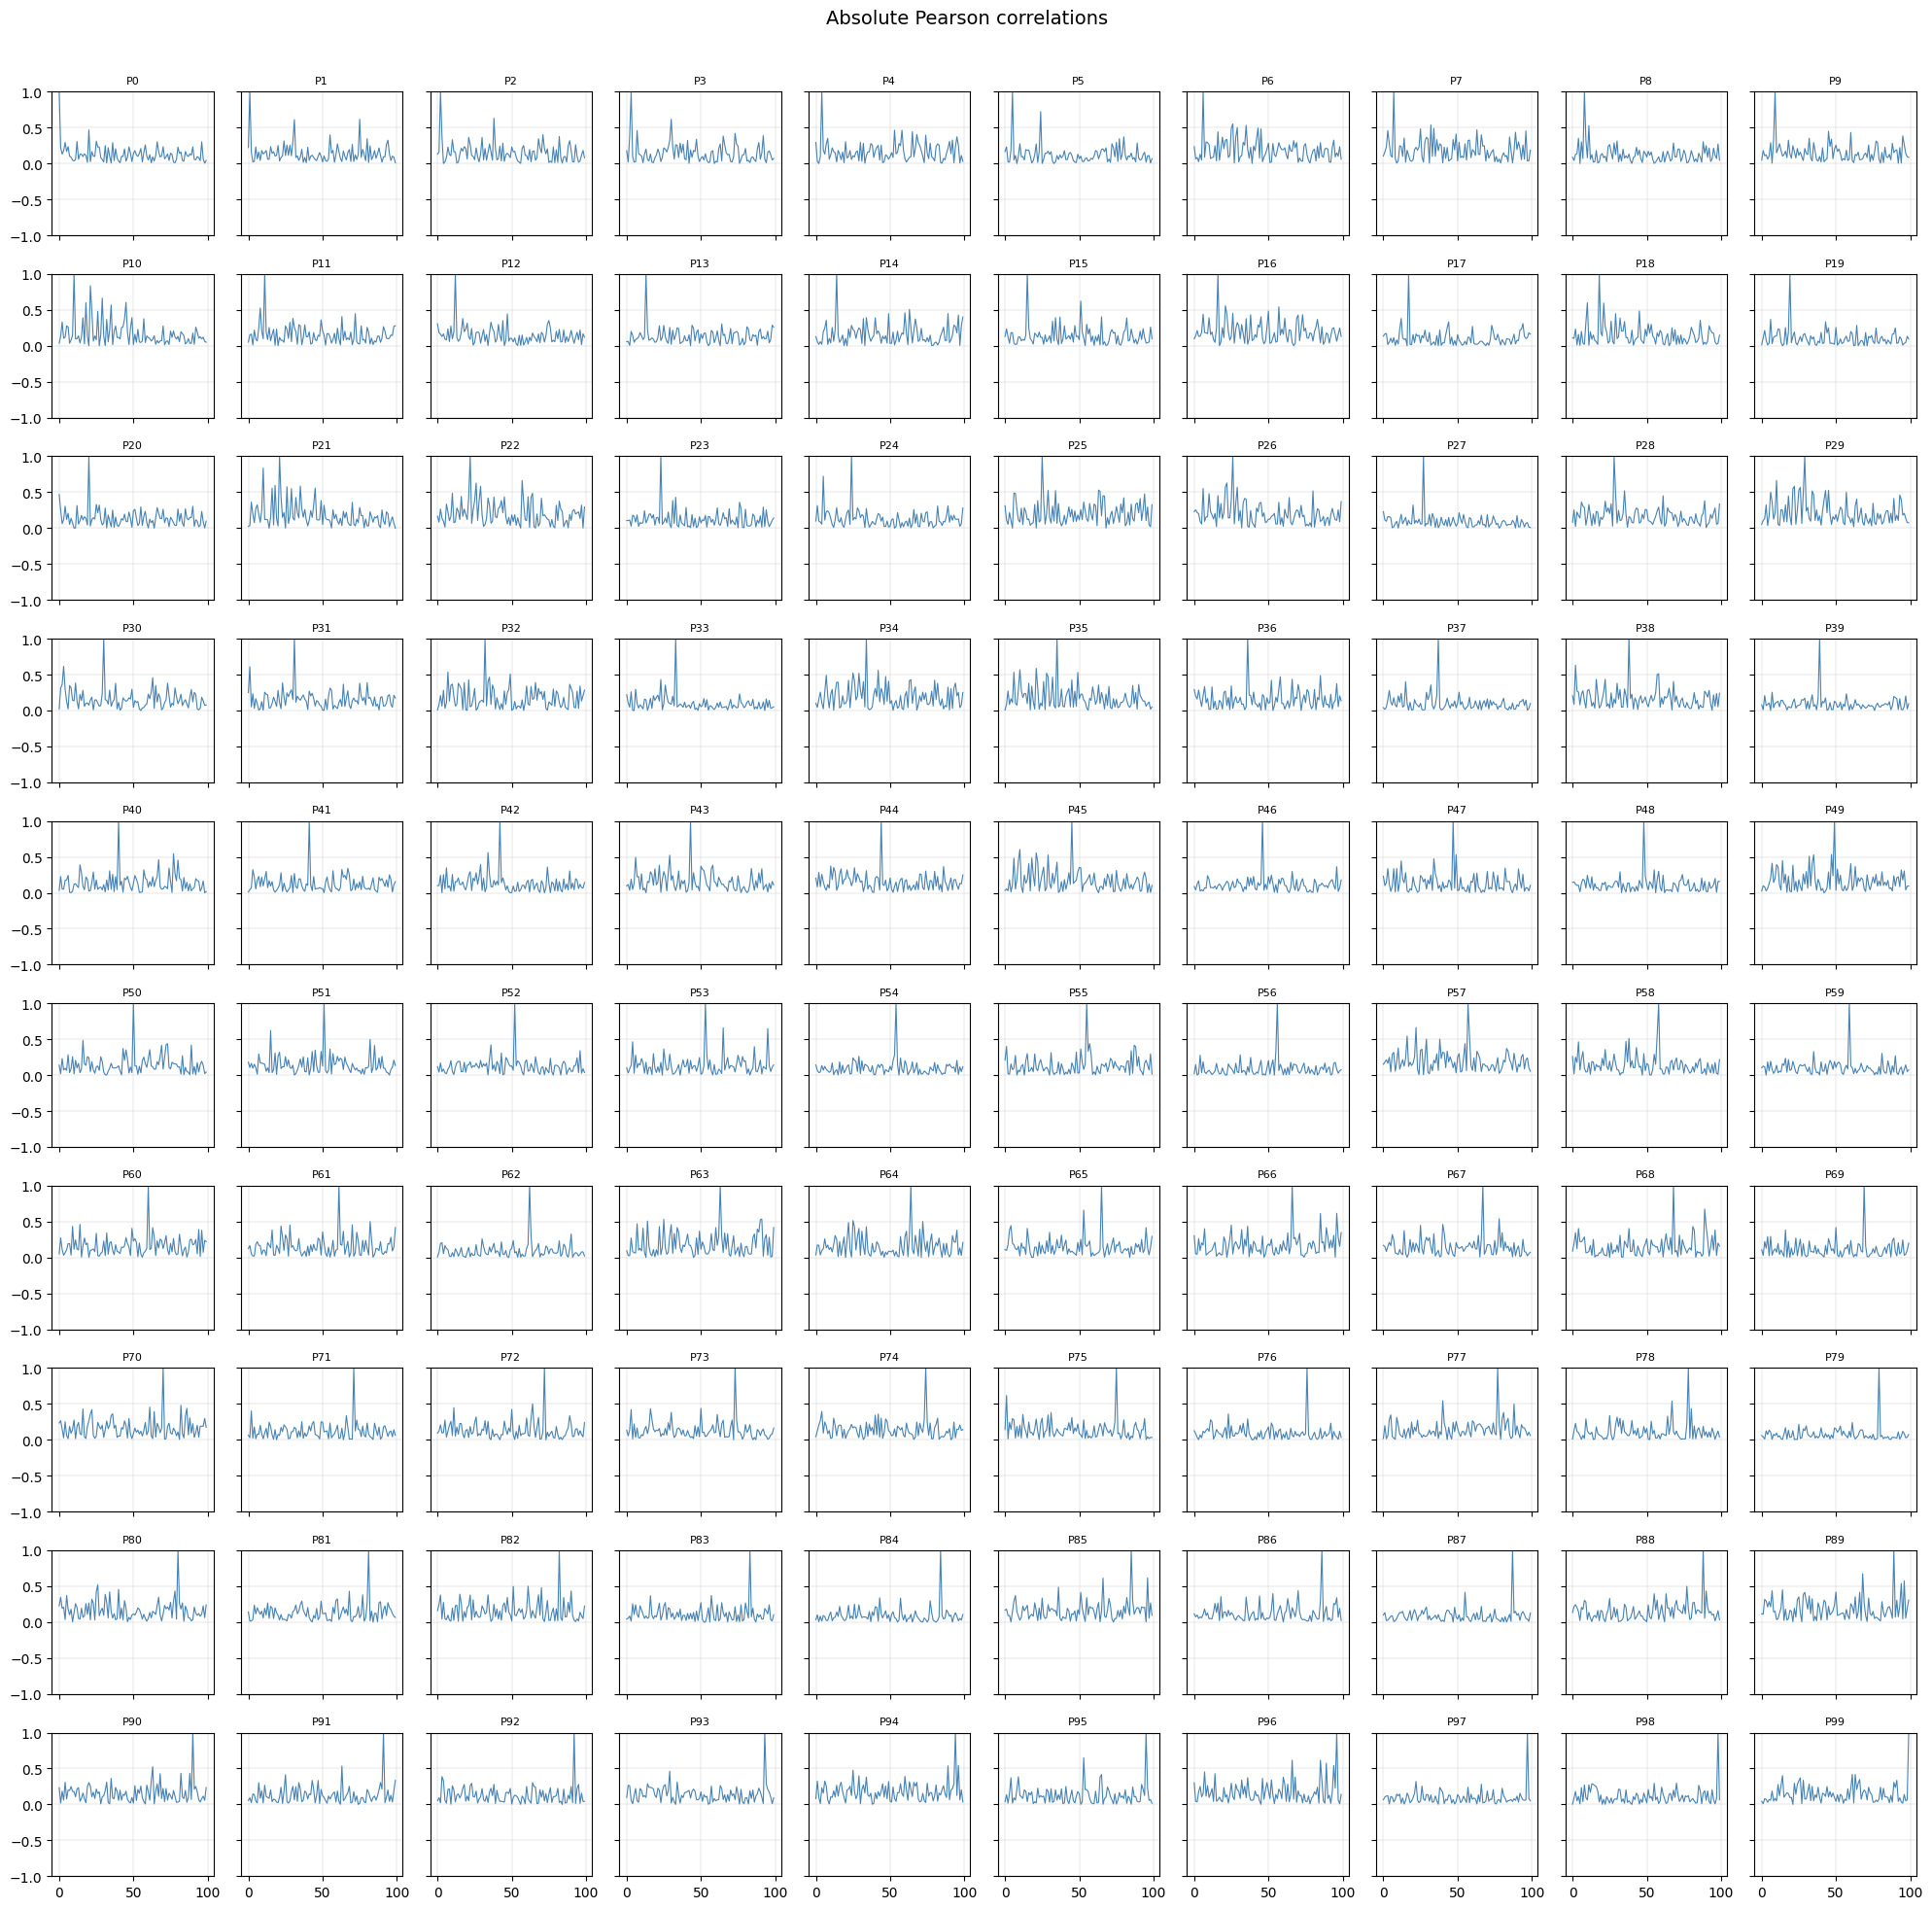

/tmp/ipython-input-1196304099.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", np.unique(y).size)


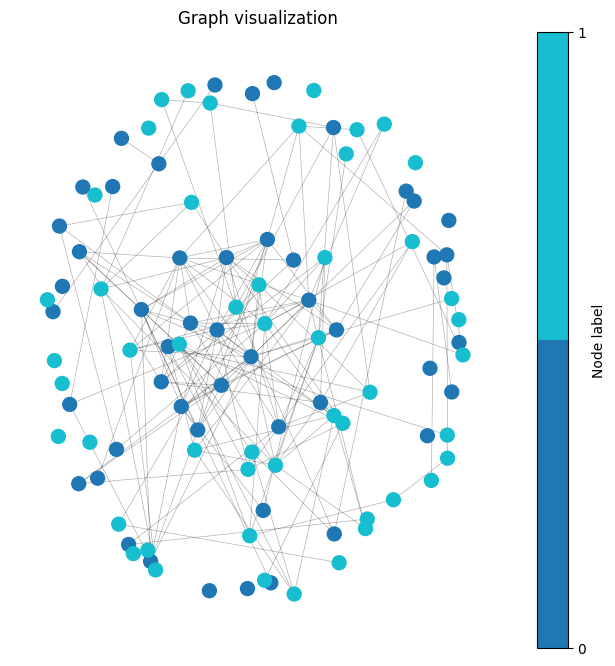

Test accuracy: 0.6000
Mean=0.6000, 95% CI=(nan, nan)
Test accuracy: 0.7000
Mean=0.6500, 95% CI=(0.0147, 1.2853)
Test accuracy: 0.4000
Mean=0.5667, 95% CI=(0.1872, 0.9461)
Test accuracy: 0.7000
Mean=0.6000, 95% CI=(0.3750, 0.8250)
Test accuracy: 0.6000
Mean=0.6000, 95% CI=(0.4479, 0.7521)
Test accuracy: 0.7000
Mean=0.6167, 95% CI=(0.4940, 0.7394)
Test accuracy: 0.4000
Mean=0.5857, 95% CI=(0.4613, 0.7101)
Test accuracy: 0.9000
Mean=0.6250, 95% CI=(0.4855, 0.7645)
Test accuracy: 0.6000
Mean=0.6222, 95% CI=(0.5020, 0.7424)
Test accuracy: 0.7000
Mean=0.6300, 95% CI=(0.5231, 0.7369)
Test accuracy: 0.9000
Mean=0.6545, 95% CI=(0.5447, 0.7644)
Test accuracy: 0.7000
Mean=0.6583, 95% CI=(0.5589, 0.7577)
Test accuracy: 1.0000
Mean=0.6846, 95% CI=(0.5775, 0.7917)
Test accuracy: 0.6000
Mean=0.6786, 95% CI=(0.5794, 0.7777)
Test accuracy: 0.5000
Mean=0.6667, 95% CI=(0.5715, 0.7618)
Test accuracy: 0.5000
Mean=0.6562, 95% CI=(0.5651, 0.7474)
Test accuracy: 0.7000
Mean=0.6588, 95% CI=(0.5734, 0.7442)
Tes

In [37]:
global_seed = None
set_common_seeds(global_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

number_of_nodes = int(normalized_data.shape[0])
number_of_dimensions = int(normalized_data.shape[1])

features_correlation = pearson_abs_tensor

show_correlations(features_correlation)
edge_index = create_sparse_edges_with_threshold(features_correlation, 0.4)

visualize_graph(normalized_data, edge_index, number_of_nodes, raw_labels)

accuracies = []

for seed in seed_pool:

    set_common_seeds(seed)

    train_mask, val_mask, test_mask = create_dataset_masks(
        points=number_of_nodes,
        train_split=0.8,
        val_split=0.1,
        test_split=0.1,
        seed=seed,
    )

    model = GNN(
        input_channels=number_of_dimensions,
        hidden_channels=32,
        output_channels=2,
        layers=2,
        dropout=0.37,
    )

    train_mask = merge_dataset_masks(train_mask, val_mask)

    train_accuracy, eval_accuracy, best_eval_accuracy = train_network(
        model=model,
        device=device,
        features=normalized_data,
        labels=raw_labels,
        edge_index=edge_index,
        train_mask=train_mask,
        eval_mask=test_mask,
        epochs=1000,
        patience=100,
        learning_rate=0.0005,
        weight_decay=1.1544729236398864e-06,
        verbose=False,
    )

    print(f"Test accuracy: {best_eval_accuracy:.4f}")

    accuracies.append(best_eval_accuracy)

    mean, lo, hi = mean_confidence_interval(accuracies)
    print(f"Mean={mean:.4f}, 95% CI=({lo:.4f}, {hi:.4f})")


Over multiple random splits, the GNN with threshold‑based edges achieves a mean test accuracy of ≈0.68 with a 95% confidence interval of ≈[0.61, 0.74], indicating high variability and limited gains over chance.

The graph built with threshold‑based edges produces a layout where nodes of different classes are heavily mixed and only loosely clustered, indicating that the resulting topology offers limited class separation and weak structural signal for the GNN.

#### KNN

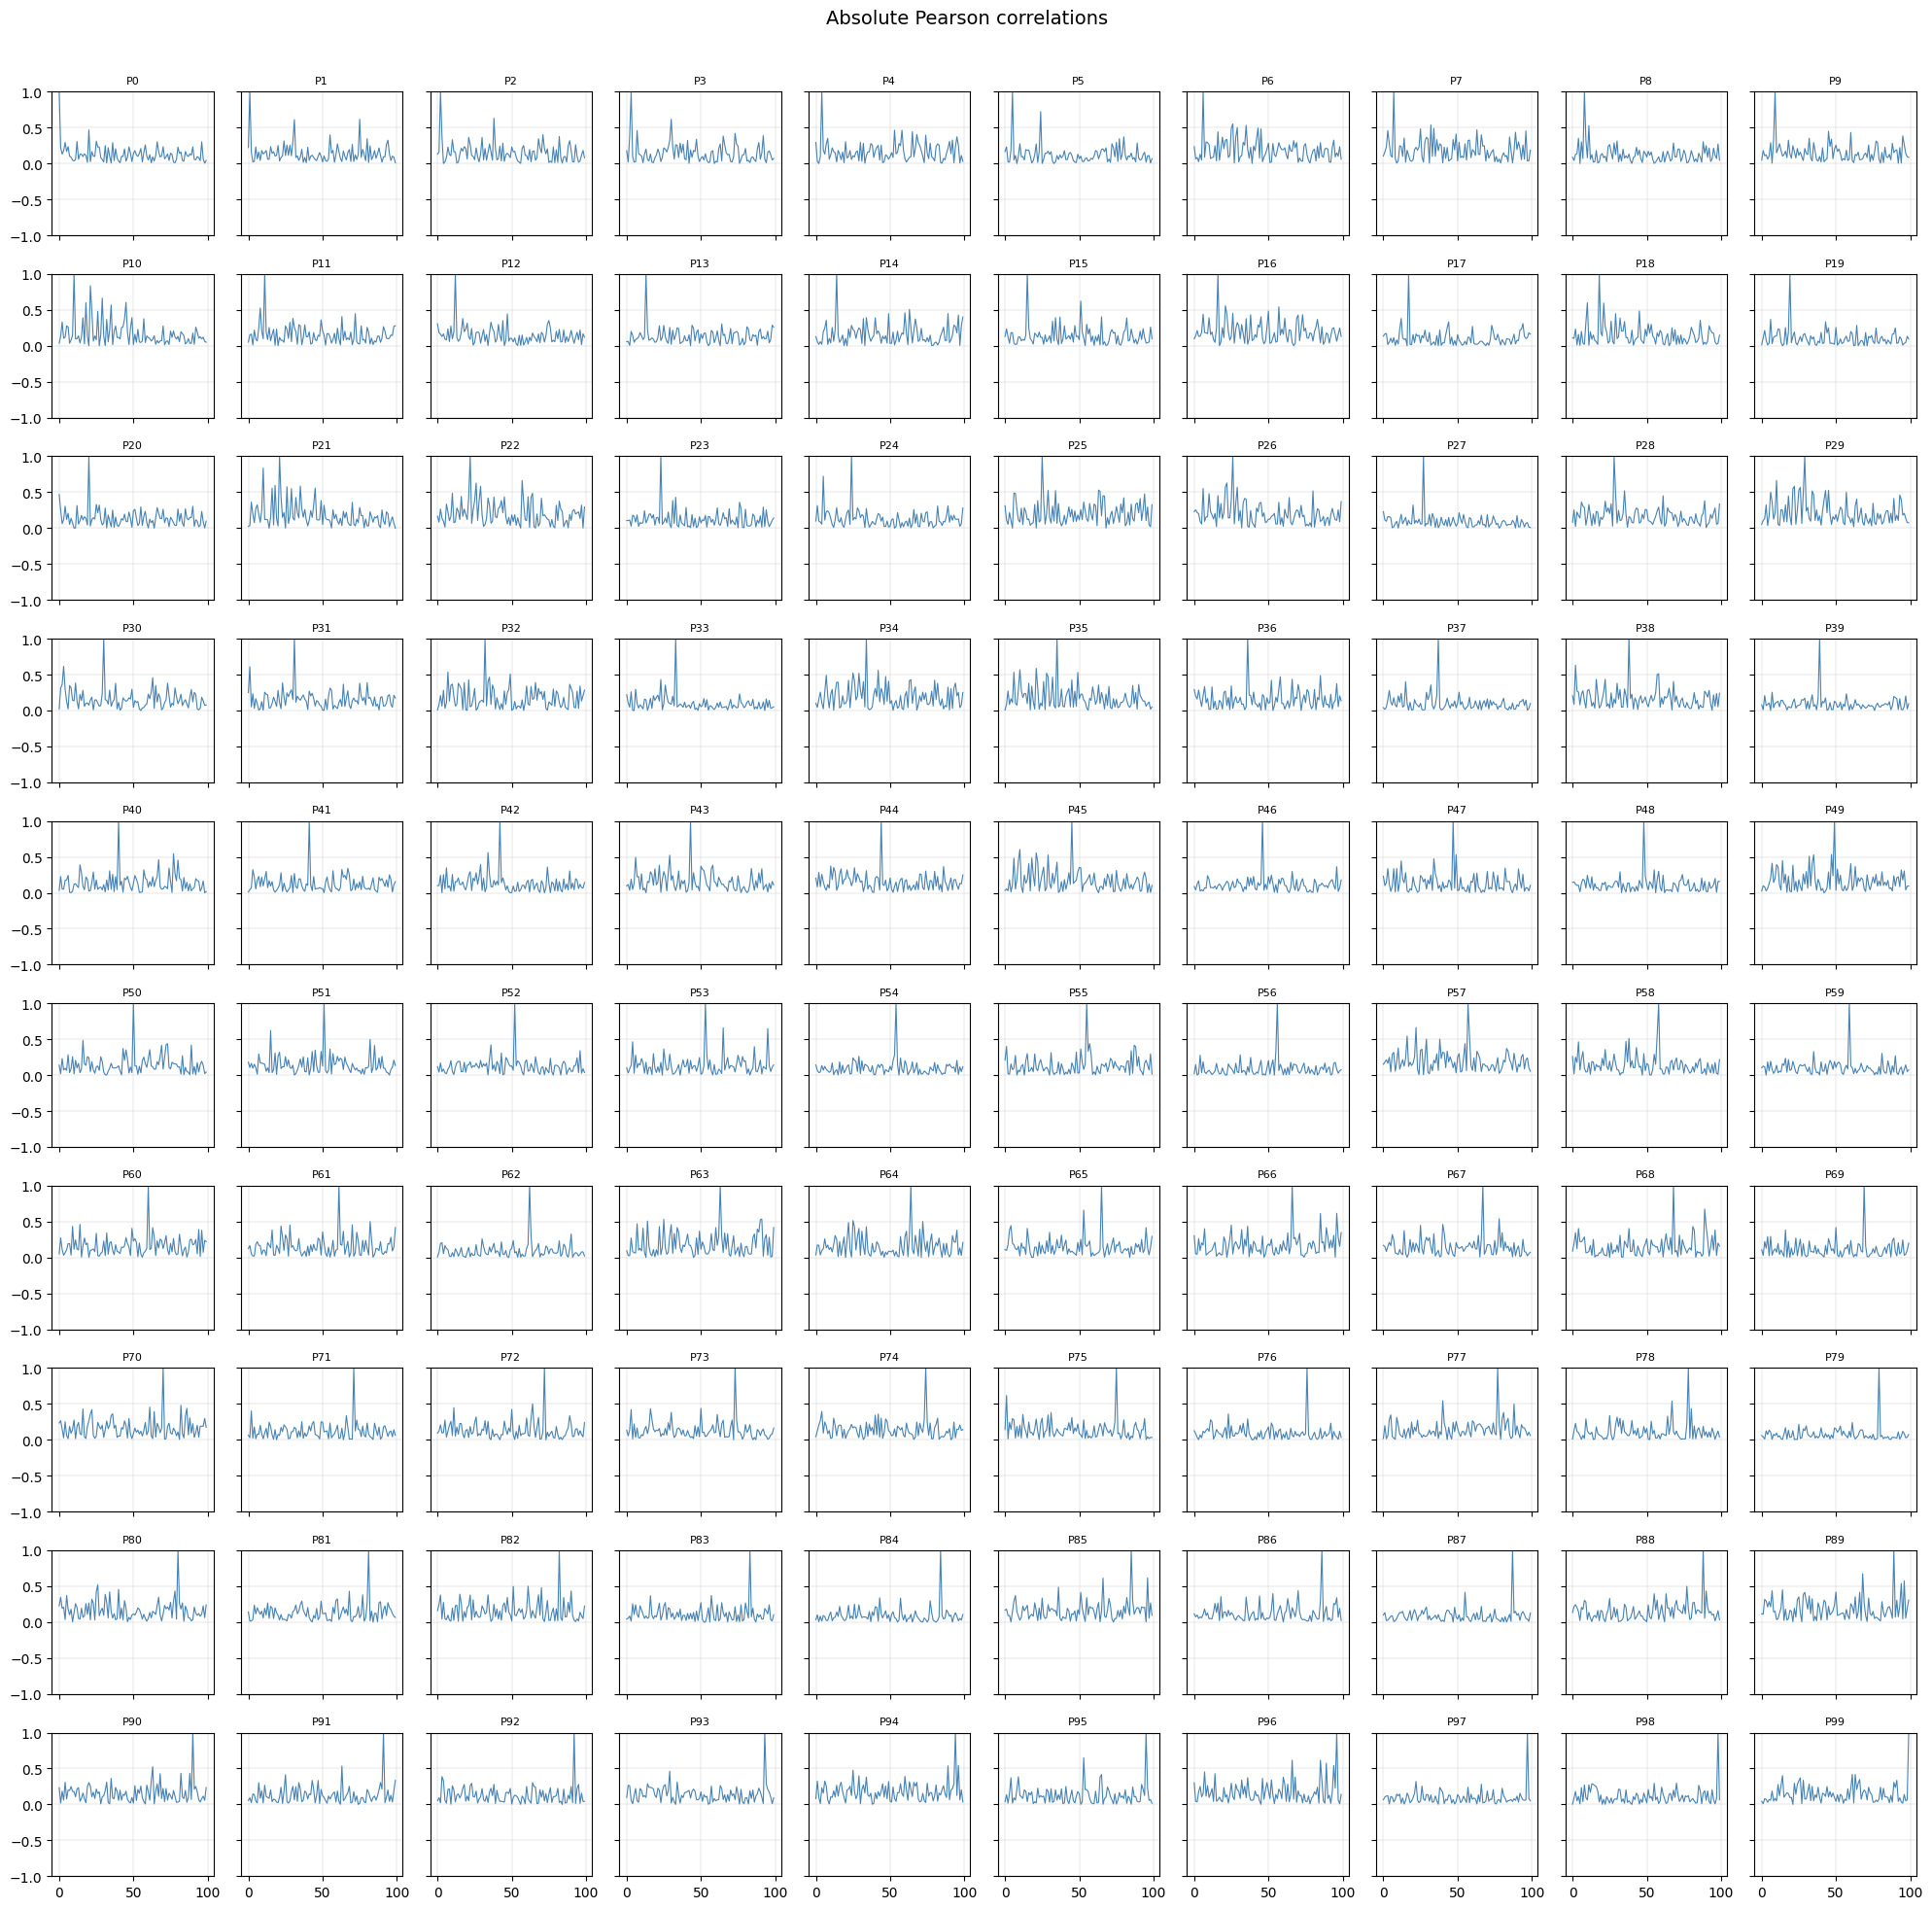

/tmp/ipython-input-1196304099.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", np.unique(y).size)


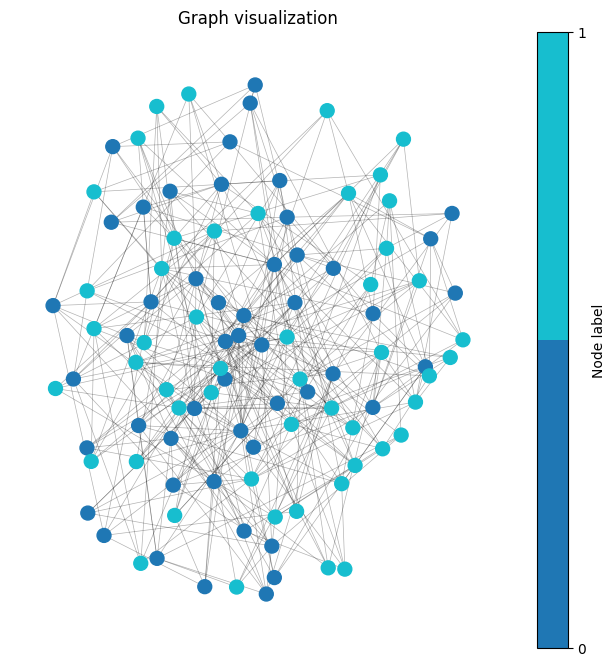

Test accuracy: 0.6000
Mean=0.6000, 95% CI=(nan, nan)
Test accuracy: 0.8000
Mean=0.7000, 95% CI=(-0.5706, 1.9706)
Test accuracy: 0.7000
Mean=0.7000, 95% CI=(0.4516, 0.9484)
Test accuracy: 0.9000
Mean=0.7500, 95% CI=(0.5446, 0.9554)
Test accuracy: 0.8000
Mean=0.7600, 95% CI=(0.6184, 0.9016)
Test accuracy: 0.7000
Mean=0.7500, 95% CI=(0.6399, 0.8601)
Test accuracy: 0.6000
Mean=0.7286, 95% CI=(0.6257, 0.8315)
Test accuracy: 0.9000
Mean=0.7500, 95% CI=(0.6501, 0.8499)
Test accuracy: 0.9000
Mean=0.7667, 95% CI=(0.6725, 0.8608)
Test accuracy: 0.6000
Mean=0.7500, 95% CI=(0.6592, 0.8408)
Test accuracy: 0.9000
Mean=0.7636, 95% CI=(0.6772, 0.8501)
Test accuracy: 0.8000
Mean=0.7667, 95% CI=(0.6885, 0.8449)
Test accuracy: 0.8000
Mean=0.7692, 95% CI=(0.6978, 0.8407)
Test accuracy: 0.8000
Mean=0.7714, 95% CI=(0.7057, 0.8372)
Test accuracy: 0.7000
Mean=0.7667, 95% CI=(0.7050, 0.8283)
Test accuracy: 0.6000
Mean=0.7563, 95% CI=(0.6948, 0.8177)
Test accuracy: 0.8000
Mean=0.7588, 95% CI=(0.7012, 0.8165)
Te

In [38]:
global_seed = None
set_common_seeds(global_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

number_of_nodes = int(normalized_data.shape[0])
number_of_dimensions = int(normalized_data.shape[1])

features_correlation = pearson_abs_tensor

show_correlations(features_correlation)

edge_index = create_sparse_edges_with_knn(features_correlation, k=5)

visualize_graph(normalized_data, edge_index, number_of_nodes, raw_labels)

accuracies = []

for seed in seed_pool:

    set_common_seeds(seed)

    train_mask, val_mask, test_mask = create_dataset_masks(
        points=number_of_nodes,
        train_split=0.8,
        val_split=0.1,
        test_split=0.1,
        seed=seed,
    )

    model = GNN(
        input_channels=number_of_dimensions,
        hidden_channels=64,
        output_channels=2,
        layers=2,
        dropout=0.39,
    )

    train_mask = merge_dataset_masks(train_mask, val_mask)

    train_accuracy, eval_accuracy, best_eval_accuracy = train_network(
        model=model,
        device=device,
        features=normalized_data,
        labels=raw_labels,
        edge_index=edge_index,
        train_mask=train_mask,
        eval_mask=test_mask,
        epochs=1000,
        patience=100,
        learning_rate=0.002,
        weight_decay=0.0004,
        verbose=False,
    )

    # print(f"Last train accuracy: {last_train_accuracy:.4f}")
    print(f"Test accuracy: {best_eval_accuracy:.4f}")

    accuracies.append(best_eval_accuracy)

    mean, lo, hi = mean_confidence_interval(accuracies)
    print(f"Mean={mean:.4f}, 95% CI=({lo:.4f}, {hi:.4f})")


Over multiple random splits, the GNN with kNN‑based edges achieves a mean test accuracy of roughly 0.77, with a 95% confidence interval stabilizing around
[
0.71
,
0.81
].
This indicates substantially better performance and lower uncertainty compared to the threshold‑based graph, suggesting that the kNN construction provides a stronger and more stable signal for classification.

From the graph visualization, the kNN‑based patient graph appears denser and more structured, with clearer local clusters formed by nodes that are highly correlated in the PCA feature space.
Node colors (class labels) tend to group into more homogeneous regions than in the threshold case, visually supporting the quantitative results and indicating that the kNN topology aligns better with the underlying class structure.

# MLP

For completeness and comparison, we also evaluated a standard MLP trained on the same dataset and tasked with the same binary classification problem. This allows us to directly contrast a non‑graph baseline with the GNN models and better understand the actual benefit of exploiting the patient‑patient graph structure.

The MLP class implements a fully connected neural network for classification on vector inputs (no graph structure).
In the constructor, it builds a sequence of linear layers: the first maps from input_channels to hidden_channels, any intermediate layers keep the same hidden size, and the final layer maps from hidden_channels to output_channels, producing the class logits.



The forward() method passes the input `x` through each linear layer in `self.layers`.
After every layer except the last, it applies a ReLU activation followed by dropout with probability `self.dropout`, which introduces non‑linearity and helps reduce overfitting by randomly zeroing some activations during training.

In [39]:
class MLP(torch.nn.Module):
    def __init__(
        self, input_channels, hidden_channels, output_channels, num_layers, dropout
    ):
        super().__init__()

        self.dropout = dropout
        self.layers = torch.nn.ModuleList()

        self.layers.append(torch.nn.Linear(input_channels, hidden_channels))

        for _ in range(num_layers - 2):
            self.layers.append(torch.nn.Linear(hidden_channels, hidden_channels))

        self.layers.append(torch.nn.Linear(hidden_channels, output_channels))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)

            # activation and dropout on all layers except the last
            if i < len(self.layers) - 1:
                x = x.relu()
                x = F.dropout(x, p=self.dropout, training=self.training)

        return x


The function `calculate_mlp_accuracy()` computes the classification accuracy for the MLP.
It first takes the argmax over the class dimension of `out` to obtain the predicted class for each sample, then compares these predictions with the ground‑truth labels only on the positions indicated by `mask`, and finally returns the fraction of correctly classified samples.


In [40]:
def calculate_mlp_accuracy(out, labels, mask):
    prediction = out.argmax(dim=1)
    correct_labels = prediction[mask] == labels[mask]
    accuracy = int(correct_labels.sum()) / int(mask.sum())
    return accuracy

This function trains the MLP on the PCA features using cross‑entropy loss and the Adam optimizer.

At each epoch, the model is updated on the training samples (`train_mask`) and then evaluated on both the training and validation sets (`eval_mask`) using `calculate_mlp_accuracy`.

The best validation accuracy is tracked: whenever it improves, the current weights are saved; if it does not improve for a given number of epochs (`patience`), training stops early and the best weights are restored.

The function returns the final training accuracy, the last validation accuracy, and the best validation accuracy achieved during training.

In [41]:
def train_mlp_network(
    model: MLP,
    device,
    features,
    labels,
    train_mask,
    eval_mask,
    epochs,
    patience,
    learning_rate,
    weight_decay,
    verbose=False,
):
    model = model.to(device)
    features = features.to(device)
    labels = labels.to(device)
    train_mask = train_mask.to(device)
    eval_mask = eval_mask.to(device)

    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay
    )
    criterion = torch.nn.CrossEntropyLoss()

    best_eval_accuracy = 0
    patience_counter = 0
    best_state = None

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(features)
        loss = criterion(out[train_mask], labels[train_mask])
        loss.backward()
        optimizer.step()

        model.eval()

        with torch.no_grad():
            out = model(features)
            train_accuracy = calculate_mlp_accuracy(out, labels, train_mask)
            eval_accuracy = calculate_mlp_accuracy(out, labels, eval_mask)

        if verbose:
            print(
                f"Epoch {epoch:03d} | Loss={loss:.4f} | Train={train_accuracy:.4f} | Eval={eval_accuracy:.4f}"
            )

        if eval_accuracy > best_eval_accuracy:
            best_eval_accuracy = eval_accuracy
            patience_counter = 0
            best_state = {k: v.clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1

        if patience_counter >= patience:
            if verbose:
                print(f"Early stopping at epoch {epoch:03d}")
            break

    if best_state is not None:
        model.load_state_dict(best_state)

    return train_accuracy, eval_accuracy, best_eval_accuracy

The `objective()` function defines the search space for Optuna when tuning the MLP.

An MLP with the hyperparameters shown is instantiated and trained using `train_mlp_network()` on the training mask, while performance is monitored on the evaluation mask.

The function returns the best validation accuracy reached during training for that trial, which Optuna will try to maximize.


In [42]:
def objective(trial: Trial, device, features, labels, train_mask, eval_mask):

    hidden_channels = trial.suggest_categorical("hidden_channels", [8, 16, 32, 64, 128])
    num_layers = trial.suggest_int("num_layers", 2, 5)
    dropout = trial.suggest_float("dropout", 0.1, 0.7)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    epochs = 1000
    patience = 100
    input_channels = features.size(1)

    model = MLP(
        input_channels=input_channels,
        hidden_channels=hidden_channels,
        output_channels=2,
        num_layers=num_layers,
        dropout=dropout,
    )

    train_accuracy, eval_accuracy, best_eval_accuracy = train_mlp_network(
          model=model,
          device=device,
          features=features,
          labels=labels,
          train_mask=train_mask,
          eval_mask=eval_mask,
          epochs=epochs,
          patience=patience,
          learning_rate=learning_rate,
          weight_decay=weight_decay,
          verbose=False,
    )

    return best_eval_accuracy

In [43]:
def execute_mlp_hpo(device, features, labels, train_mask, eval_mask, trials=100):

    wrapped_objective = partial(
        objective,
        device=device,
        features=features,
        labels=labels,
        train_mask=train_mask,
        eval_mask=eval_mask,
    )

    study = optuna.create_study(direction="maximize")
    study.optimize(wrapped_objective, n_trials=trials)

    print("Best value:", study.best_value)
    print("Best params:", study.best_params)

    return study

This code cell prepares and runs hyperparameter optimization for the MLP baseline on the PCA‑transformed dataset.

A fixed seed is used to create a reproducible 80/10/10 train–validation–test split via boolean masks, and the computation device (CPU or GPU) is selected automatically.

The function `execute_mlp_hpo()` is then called to explore 100 different MLP configurations, training on the training mask and evaluating on the validation mask, in order to identify the set of hyperparameters that yields the highest validation accuracy.

In [ ]:
global_seed = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

number_of_nodes = int(normalized_data.shape[0])
number_of_dimensions = int(normalized_data.shape[1])
number_of_patients = n_patients

train_mask, val_mask, test_mask = create_dataset_masks(
    points=number_of_nodes,
    train_split=0.8,
    val_split=0.1,
    test_split=0.1,
    seed=global_seed,
)

study = execute_mlp_hpo(
    device = device,
    features=normalized_data,
    labels=raw_labels,
    train_mask=train_mask,
    eval_mask=val_mask,
    trials=100,
)


The optimal values obtained are:


```
Best value: 1.0
Best params: {'hidden_channels': 32, 'num_layers': 2, 'dropout': 0.26348015938250063, 'learning_rate': 0.0006418306173258966, 'weight_decay': 0.00019657042655024006}
```



The optimal values obtained with HPO are then used in the effective training of the network.

In [46]:
global_seed = None
set_common_seeds(global_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

number_of_nodes = int(normalized_data.shape[0])
number_of_dimensions = int(normalized_data.shape[1])

accuracies = []

for seed in seed_pool:

  set_common_seeds(seed)

  train_mask, val_mask, test_mask = create_dataset_masks(
      points=number_of_nodes,
      train_split=0.8,
      val_split=0.1,
      test_split=0.1,
      seed=seed,
  )

  model = MLP(
      input_channels=number_of_dimensions,
      hidden_channels=32,
      output_channels=2,
      num_layers=2,
      dropout=0.26,
  )

  train_mask = merge_dataset_masks(train_mask, val_mask)

  train_accuracy, eval_accuracy, best_eval_accuracy = train_mlp_network(
      model=model,
      device=device,
      features=normalized_data,
      labels=raw_labels,
      train_mask=train_mask,
      eval_mask=test_mask,
      epochs=1000,
      patience=100,
      learning_rate=0.0006,
      weight_decay=0.0002,
      verbose=False,
  )
  print(f"Test accuracy: {best_eval_accuracy:.4f}")

  accuracies.append(best_eval_accuracy)


mean, lo, hi = mean_confidence_interval(accuracies)
hw = (hi - lo) / 2.0
print(f"Mean={mean:.4f}, Half width={hw:.4f}, CI=({lo:.4f}, {hi:.4f})")



Test accuracy: 0.7000
Test accuracy: 0.8000
Test accuracy: 0.8000
Test accuracy: 0.8000
Test accuracy: 0.7000
Test accuracy: 0.7000
Test accuracy: 0.8000
Test accuracy: 0.8000
Test accuracy: 0.8000
Test accuracy: 0.9000
Test accuracy: 0.5000
Test accuracy: 0.8000
Test accuracy: 0.7000
Test accuracy: 0.6000
Test accuracy: 0.5000
Test accuracy: 0.6000
Test accuracy: 0.9000
Test accuracy: 0.8000
Test accuracy: 0.8000
Test accuracy: 0.6000
Test accuracy: 1.0000
Test accuracy: 0.7000
Test accuracy: 0.8000
Test accuracy: 0.9000
Test accuracy: 0.7000
Test accuracy: 0.9000
Test accuracy: 0.8000
Test accuracy: 0.8000
Test accuracy: 0.9000
Test accuracy: 0.9000
Mean=0.7667, Half width=0.0453, CI=(0.7214, 0.8120)


MLP and GNN (with KNN) yield nearly identical performance:
* MLP mean=0.7667 (95% CI: 0.7214-0.8120)
* GNN mean=0.7667 (95% CI: 0.7173-0.8160).

There's no mean difference between the models indicating no reliable superiority of one model over another.





Both models achieve comparable accuracy because the task likely involves data where local neighborhood structures (captured by GNN+KNN) do not provide a decisive edge over MLP's global feature learning. MLPs excel at capturing non-spatial patterns effectively, while GNN's graph-based inductive biases may offer minimal gains if graph topology is simple or noisy, resulting in overlapping uncertainty ranges.


Performance Comparison Table
| Model   | Mean   | 95% CI          |                  |
|---------|--------|-----------------|-
| MLP     | 0.7667 | [0.7214, 0.8120]|
| GNN+KNN | 0.7667 | [0.7173, 0.8160]|

No compelling evidence to prefer GNN; stick with simpler MLP unless graph structure yields future benefits. This equivalence suggests dataset limitations (e.g., weak relational signals) or sufficient MLP capacity, making GNN overhead unnecessary here.